In [2]:
import sys
import os

CURRENT_DIR = os.path.dirname(os.path.realpath("__file__"))
BASE_DIR = os.path.join(CURRENT_DIR, os.pardir)
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
ENABLE_SAVEFIG = True

sys.path.append(BASE_DIR)
sys.path.append(CURRENT_DIR)

from model.model import AdaptationModel, Wizard
from model import utils
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, mannwhitneyu

from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting

# sns.set_style()
# sns.set_theme(style = 'whitegrid', palette = 'deep')

plt.style.use("../model/myBmh.mplstyle")


if not ENABLE_SAVEFIG:
    utils.savefig = lambda *args, **kwargs: None

In [3]:
# Utilities
from itertools import product, chain
import pandas as pd
import numpy as np


def calc_col_names(named_shape):
    *prefix, shape = named_shape
    names = [map(str, range(i)) for i in shape]
    return map('_'.join, product(prefix, *names))


def create_flat_columns_df_from_dict_of_numpy(
        named_np: dict[str, np.array],
        n_samples_per_np: int,
):
    flat_nps = [a.reshape(n_samples_per_np, -1) for a in named_np.values()]
    stacked_nps = np.column_stack(flat_nps)
    named_shapes = [(name, arr.shape[1:]) for name, arr in named_np.items()]
    col_names = [*chain.from_iterable(calc_col_names(named_shape) for named_shape in named_shapes)]
    df = pd.DataFrame(stacked_nps, columns=col_names)
    df = df.convert_dtypes()
    return df


    

In [4]:
def scenario_name(s):
    name = f"RA{0 if s%16 <= 7 else 1}"
    name += f"-SS{0 if s% 8 <= 3 else 1}"
    name += f"-TG{0 if s%4 <=1 else 1}"
    name += f"-IS{0 if s%2 == 0 else 1}"
    return name

In [5]:
## Load data

# results = load_results(os.path.join(OUTPUT_DIR, "temporary.tar.gz"))
# results = load_results(os.path.join(OUTPUT_DIR, "long.tar.gz"))
# results = load_results(os.path.join(OUTPUT_DIR, "simple-parametric-h200-t80-r100-s1.tar.gz"))
results = load_results(os.path.join(OUTPUT_DIR, "ff-parametric-h200-t80-r100-s2.tar.gz"))
experiments, data = results

# Extract some information about the experiments
unique_policies = experiments["policy"].unique()
n_scenarios = data["TotalAdapted"].shape[0]
n_replications = data["TotalAdapted"].shape[1]
n_timesteps = data["TotalAdapted"].shape[2]
n_policies = len(unique_policies)
n_metrics = len(list(data.keys()))

# Reporting some information about the experiments
print(f"Analysing {n_scenarios} scenarios, with policies {list(unique_policies)}, {n_replications} replications, {n_timesteps} timesteps")

# Rename the scenarios to more readable names
for i in range(n_scenarios):
    experiments["scenario"].replace(i, scenario_name(i), inplace=True)

display(experiments[experiments["policy"] == "NoPolicy"])

Analysing 64 scenarios, with policies ['NoPolicy', 'Info', 'Subsidy', 'Info + Subsidy'], 100 replications, 80 timesteps


,avg_risk_aversion,avg_savings_per_step_vs_house,avg_trustworthiness_government,max_initial_savings,scenario,policy,model
0,0.25,-0.1,-0.1,90.0,RA0-SS0-TG0-IS0,NoPolicy,AdaptationModel
1,0.25,-0.1,-0.1,500.0,RA0-SS0-TG0-IS1,NoPolicy,AdaptationModel
2,0.25,-0.1,0.4,90.0,RA0-SS0-TG1-IS0,NoPolicy,AdaptationModel
3,0.25,-0.1,0.4,500.0,RA0-SS0-TG1-IS1,NoPolicy,AdaptationModel
4,0.25,0.3,-0.1,90.0,RA0-SS1-TG0-IS0,NoPolicy,AdaptationModel
5,0.25,0.3,-0.1,500.0,RA0-SS1-TG0-IS1,NoPolicy,AdaptationModel
6,0.25,0.3,0.4,90.0,RA0-SS1-TG1-IS0,NoPolicy,AdaptationModel
7,0.25,0.3,0.4,500.0,RA0-SS1-TG1-IS1,NoPolicy,AdaptationModel
8,0.75,-0.1,-0.1,90.0,RA1-SS0-TG0-IS0,NoPolicy,AdaptationModel
9,0.75,-0.1,-0.1,500.0,RA1-SS0-TG0-IS1,NoPolicy,AdaptationModel


In [6]:
# Usefull Dataframes
flat_dict=  {k: v.flatten() for k, v in data.items()}
df_all = pd.DataFrame(np.repeat(experiments.values, n_replications*n_timesteps, axis=0), columns=experiments.columns)
df_all["time"]= np.array([i for j in range(n_replications * n_scenarios)  for i in range(n_timesteps)])
df_all = df_all.join(pd.DataFrame(flat_dict))

# Mean of the scenarios
df_scenario_mean = df_all.groupby(["policy", "scenario", "time"])[["TotalAdapted"]].mean()

# df_all = df_all[df_all["avg_savings_per_step_vs_house"] > 0.25]
# df_all = df_all[df_all["scenario"] == 1]
# df_all.head()

# df_all = df_all[df_all["scenario"].isin([0,5,6,8])]
adapting_scenarios = [scenario_name(i) for i in [4,5,6,7,12,13,14,15]]
df_all_adapt = df_all[df_all["scenario"].isin(adapting_scenarios)]

df_all_adapt.head()


,avg_risk_aversion,avg_savings_per_step_vs_house,avg_trustworthiness_government,max_initial_savings,scenario,policy,model,time,InformationAbundance,SocietalRisk,AverageRiskAversion,AverageEstimationFactor,TotalAdapted
32000,0.25,0.3,-0.1,90.0,RA0-SS1-TG0-IS0,NoPolicy,AdaptationModel,0,0.1,NaN,0.222903,0.475616,0
32001,0.25,0.3,-0.1,90.0,RA0-SS1-TG0-IS0,NoPolicy,AdaptationModel,1,0.1,0.018972,0.223181,0.470354,7
32002,0.25,0.3,-0.1,90.0,RA0-SS1-TG0-IS0,NoPolicy,AdaptationModel,2,0.1,0.017920,0.223927,0.465269,9
32003,0.25,0.3,-0.1,90.0,RA0-SS1-TG0-IS0,NoPolicy,AdaptationModel,3,0.1,0.017709,0.225371,0.460242,12
32004,0.25,0.3,-0.1,90.0,RA0-SS1-TG0-IS0,NoPolicy,AdaptationModel,4,0.1,0.017698,0.227755,0.455187,13


[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/boxplot-scenario-all.pdf


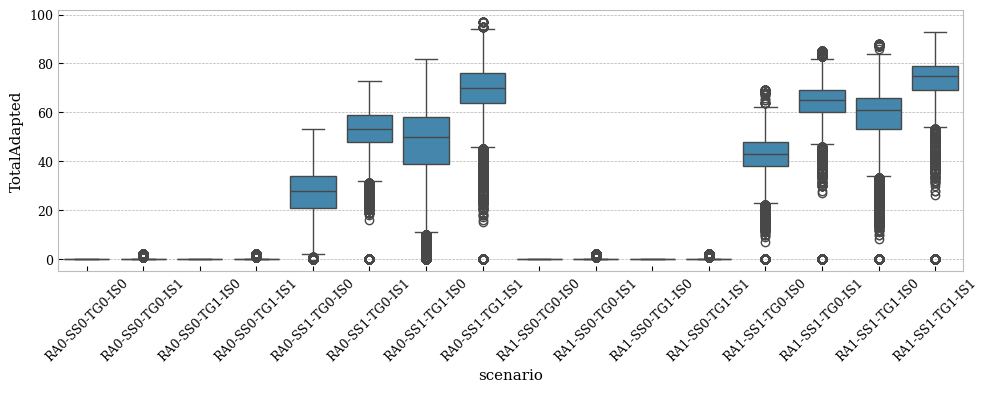

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/boxplot-scenarios.pdf


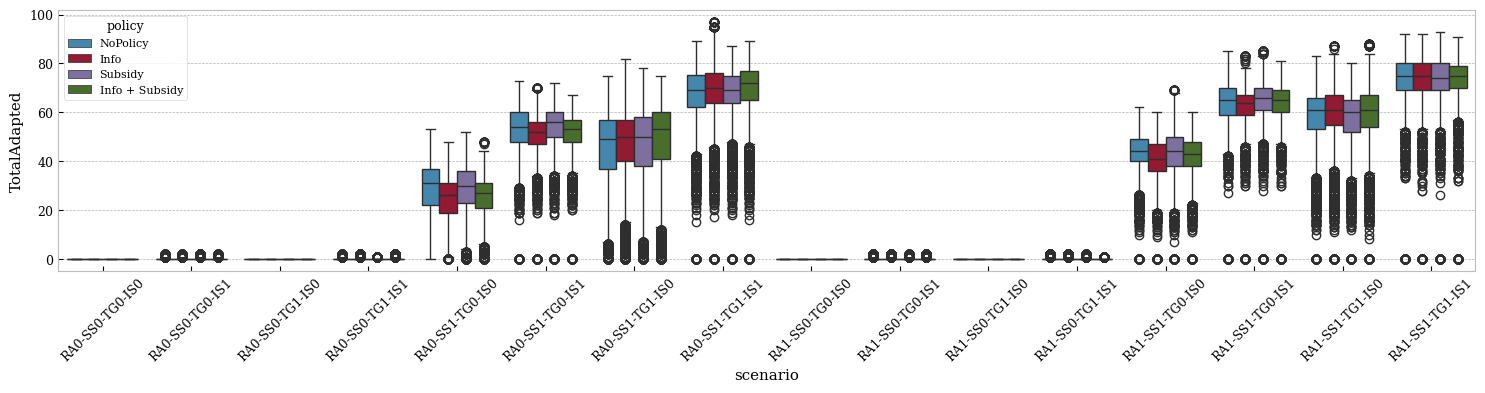

In [7]:
# sns.boxplot(x="policy", y="TotalAdapted", hue="scenario", data=df_all)
plt.figure(figsize=(10, 4))
sns.boxplot(x="scenario", y="TotalAdapted", data=df_all)
plt.xticks(rotation=45)
utils.savefig("boxplot-scenario-all.pdf", FIG_DIR)
plt.show()

plt.figure(figsize=(15, 4))
sns.boxplot(x="scenario", y="TotalAdapted", data=df_all, hue="policy")
plt.xticks(rotation=45)
utils.savefig("boxplot-scenarios.pdf", FIG_DIR)
plt.show()


/tmp/ipykernel_446225/1803278639.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stat, p = mannwhitneyu(df_tmp[df_all["policy"] == "Info"]["TotalAdapted"], df_tmp[df_tmp["policy"] == "Subsidy"]["TotalAdapted"])


Statistics=1968614432.5, p=3.075718142020816e-33
[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/kde-scenario-all.pdf


<Figure size 800x300 with 0 Axes>

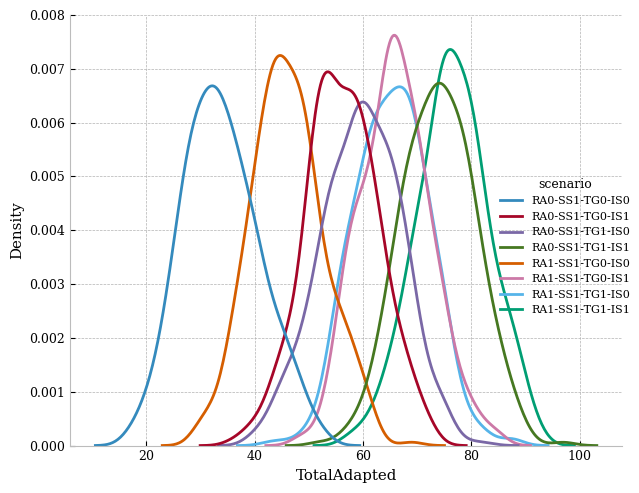

In [8]:
# Set df_tmp to the dataframe you want to plot
df_tmp = df_all_adapt

## Plotting

tf = df_tmp["time"].max()
df_end = df_tmp[df_tmp["time"] == tf]

plt.figure()
# sns.displot(data=df_end, x="TotalAdapted", hue="policy", kind="kde")
# sns.displot(data=df_end, x="TotalAdapted", hue="scenario", kind="kde", row="policy")
# sns.displot(data=df_end, x="TotalAdapted", hue="policy", kind="kde", col="scenario")
sns.displot(data=df_end, x="TotalAdapted", hue="scenario", kind="kde")

stat, p = mannwhitneyu(df_tmp[df_all["policy"] == "Info"]["TotalAdapted"], df_tmp[df_tmp["policy"] == "Subsidy"]["TotalAdapted"])
# stat, p = ttest_ind(df_end[df_all["policy"] == "Info"]["TotalAdapted"], df_end[df_all["policy"] == "Subsidy"]["TotalAdapted"])

print(f"Statistics={stat}, p={p}")
utils.savefig("kde-scenario-all.pdf", FIG_DIR)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


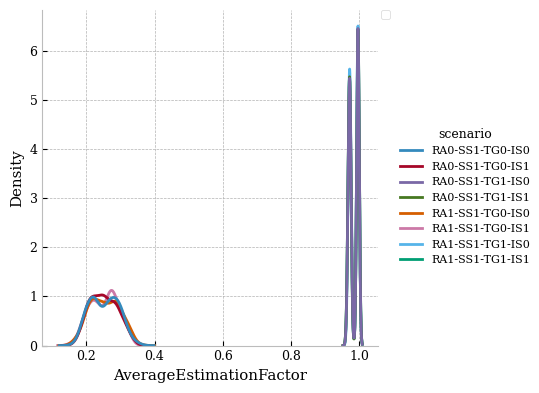

In [126]:
# sns.displot(data=df_end, x="AverageEstimationFactor", hue="policy", kind="kde", col="scenario", height=4)
sns.displot(data=df_end, x="AverageEstimationFactor", hue="scenario", kind="kde", height=4)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# utils.savefig("kde-estimation-factor.pdf", FIG_DIR)

KeyboardInterrupt: 

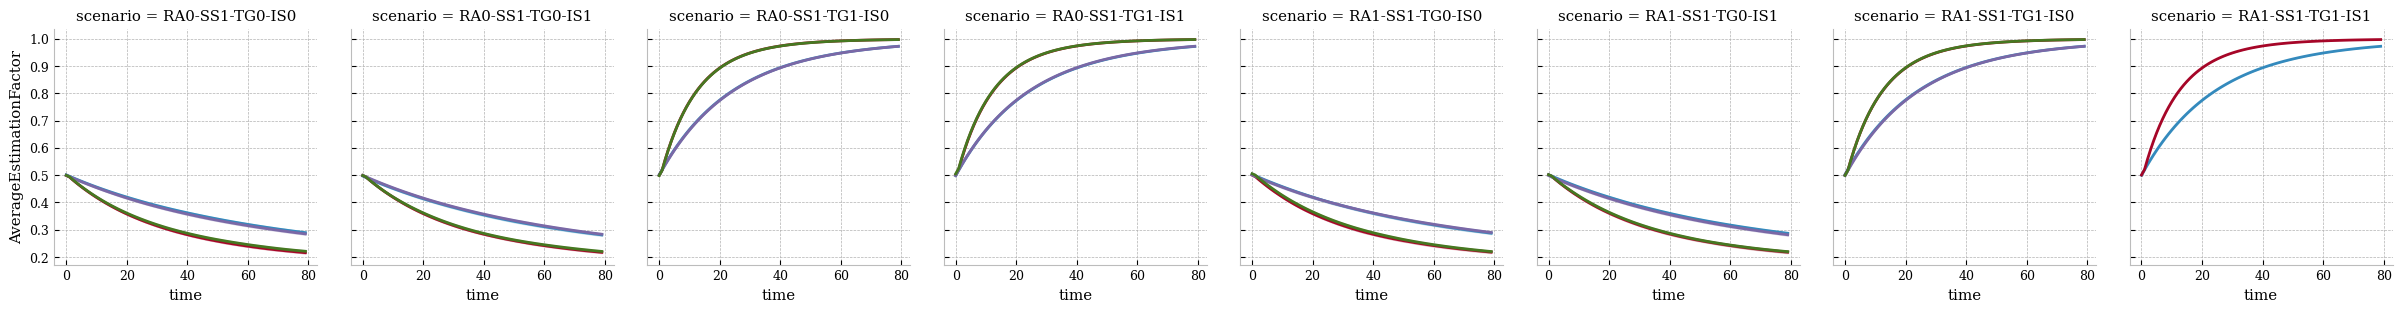

In [106]:
df_tmp = df_all_adapt

# g = sns.FacetGrid(df_all, col="policy", hue="scenario")
g = sns.FacetGrid(df_tmp, col="scenario", hue="policy")
g.map(sns.lineplot, "time", "AverageEstimationFactor")
g.add_legend()

# sns.lineplot(data=df_all, x="time", y="AverageEstimationFactor", hue="scenario")


[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/lineplot-totaladapted-scenarios.pdf


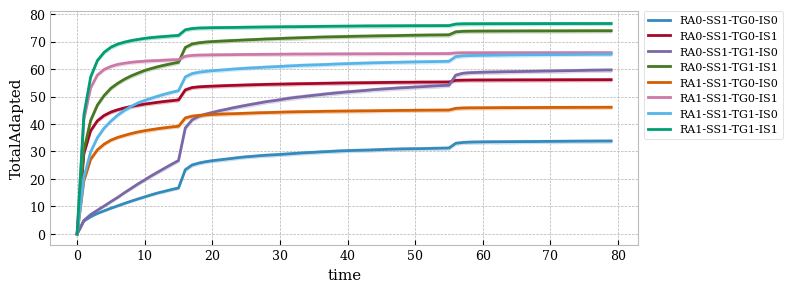

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/lineplot-totaladapted-policy.pdf


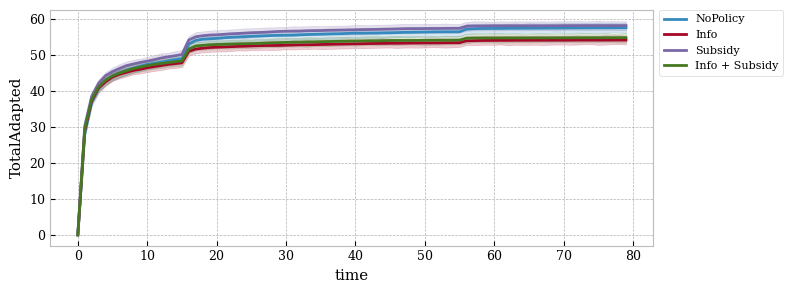

In [10]:
df_tmp = df_all_adapt

# sns.lineplot(data=df_all, x="time", y="TotalAdapted", hue="policy")
sns.lineplot(data=df_tmp, x="time", y="TotalAdapted", hue="scenario")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
utils.savefig("lineplot-totaladapted-scenarios.pdf", FIG_DIR)
plt.show()



df_tt = df_tmp[df_tmp["scenario"] == scenario_name(5)]

sns.lineplot(data=df_tt, x="time", y="TotalAdapted", hue="policy")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
utils.savefig("lineplot-totaladapted-policy.pdf", FIG_DIR)
plt.show()


[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/jointplot-risk-aversion-scenario.pdf


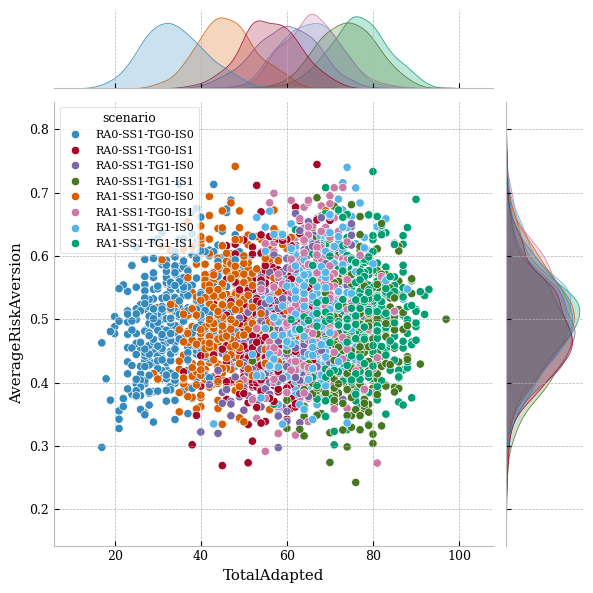

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/jointplot-risk-aversion-policy.pdf


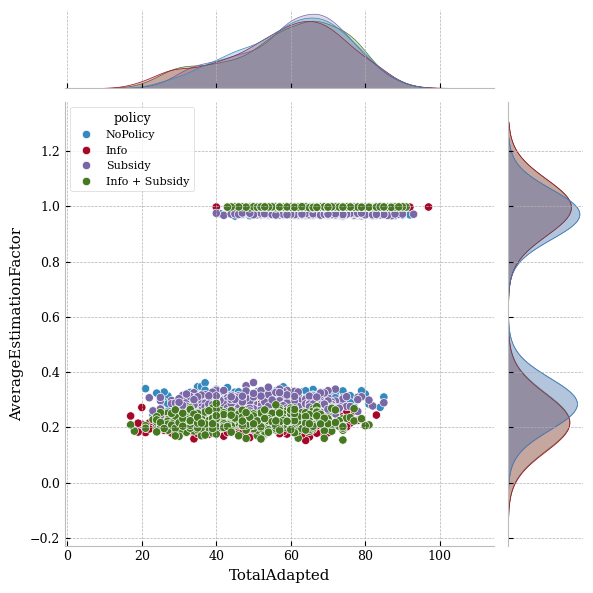

In [128]:
sns.jointplot(data=df_end, x="TotalAdapted", y="AverageRiskAversion", hue="scenario")
utils.savefig("jointplot-risk-aversion-scenario.pdf", FIG_DIR)
plt.show()

sns.jointplot(data=df_end, x="TotalAdapted", y="AverageEstimationFactor", hue="policy")
utils.savefig("jointplot-risk-aversion-policy.pdf", FIG_DIR)
plt.show()

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/pairplot-scenarios.pdf


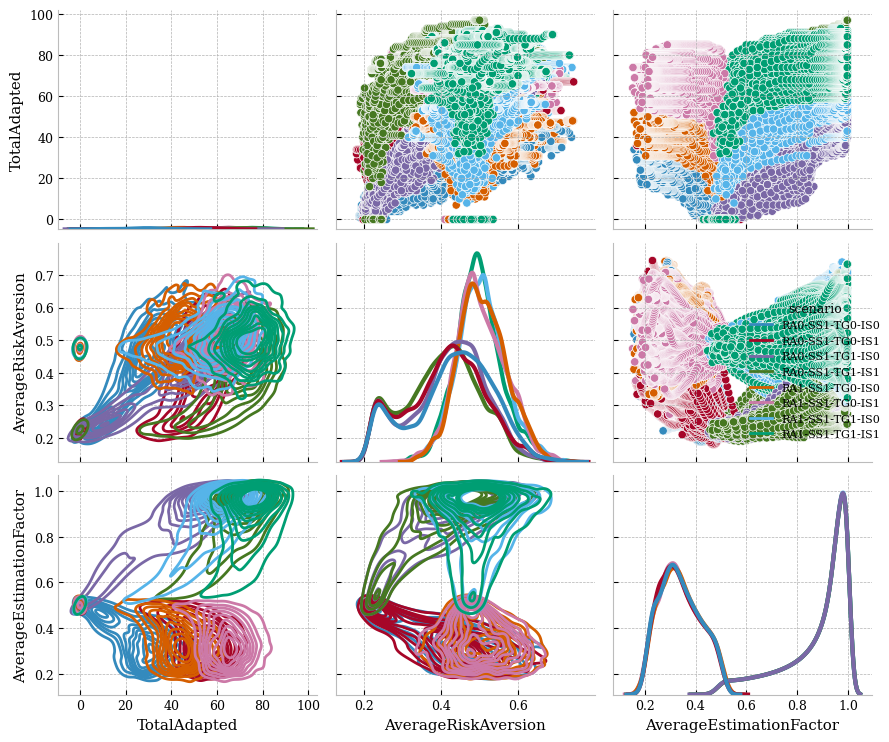

In [129]:
df_tmp = df_all_adapt

sns.color_palette("husl", 9)

# g = sns.PairGrid(df_all, vars=["TotalAdapted", "AverageRiskAversion", "AverageEstimationFactor"], hue="scenario")
g = sns.PairGrid(df_tmp, vars=["TotalAdapted", "AverageRiskAversion", "AverageEstimationFactor"], hue="scenario")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.add_legend()
utils.savefig("pairplot-scenarios.pdf", FIG_DIR)

<Axes: xlabel='time', ylabel='SocietalRisk'>

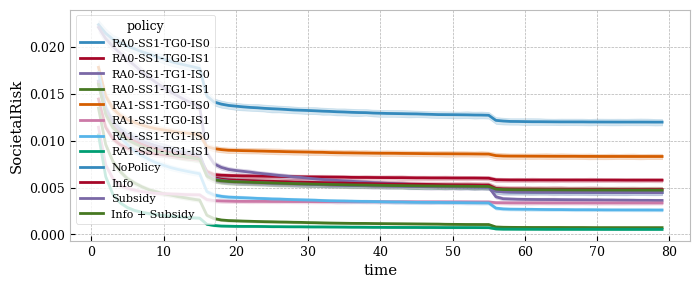

In [134]:
df_tmp = df_all_adapt


sns.lineplot(data=df_tmp, x="time", y="SocietalRisk", hue="scenario")


[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/lineplot-societal-risk-policy.pdf


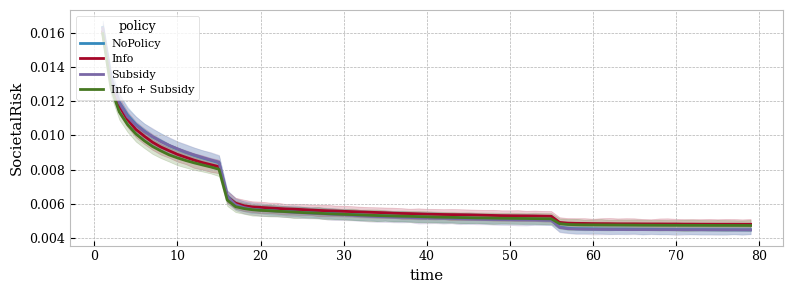

In [142]:
df_tmp = df_all_adapt

sns.lineplot(data=df_tmp, x="time", y="SocietalRisk", hue="policy")
utils.savefig("lineplot-societal-risk-policy.pdf", FIG_DIR)
plt.show()

<Axes: xlabel='scenario', ylabel='TotalAdapted'>

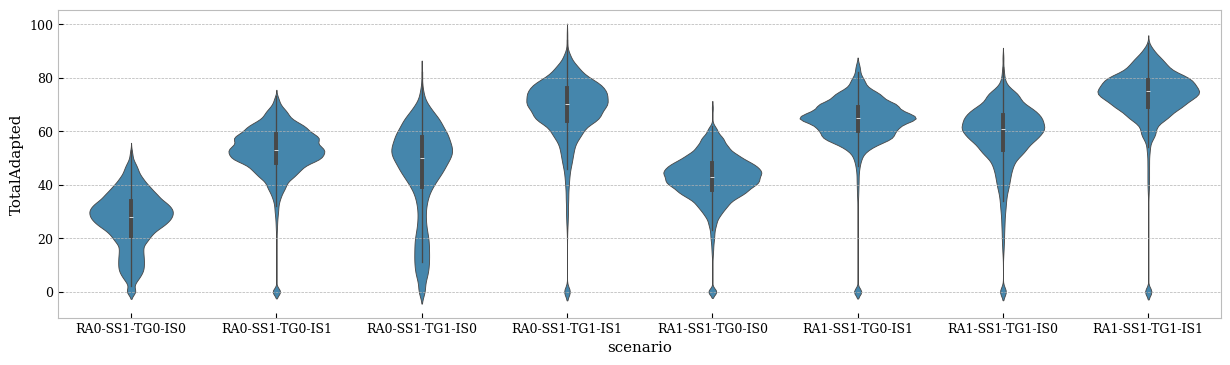

In [119]:
df_tmp = df_all_adapt

plt.figure(figsize=(15, 4))
# sns.violinplot(data=df_all, x="policy", y="TotalAdapted")
sns.violinplot(data=df_tmp, x="scenario", y="TotalAdapted")

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/lineplot-risk-aversion-scenarios.pdf


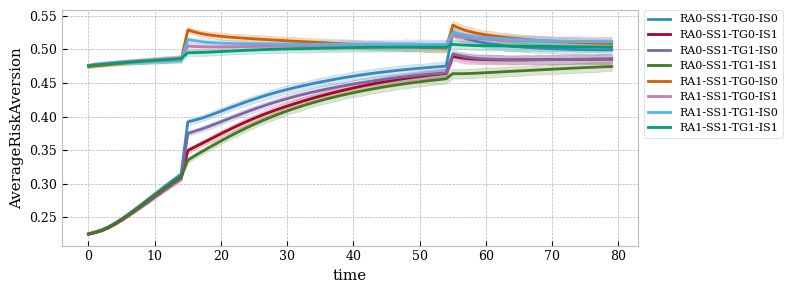

States=3744098451.0, p=1.810062354044035e-207


In [143]:
df_tmp = df_all_adapt

# sns.lineplot(data=df_all, x="time", y="AverageRiskAversion", hue="policy")
sns.lineplot(data=df_tmp, x="time", y="AverageRiskAversion", hue="scenario")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
utils.savefig("lineplot-risk-aversion-scenarios.pdf", FIG_DIR)
plt.show()


stat, p = mannwhitneyu(df_tmp[df_tmp["policy"] == "Info"]["AverageRiskAversion"], df_all[df_all["policy"] == "NoPolicy"]["AverageRiskAversion"])
print(f"States={stat}, p={p}")

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/lineplot-estimation-factore-policy.pdf


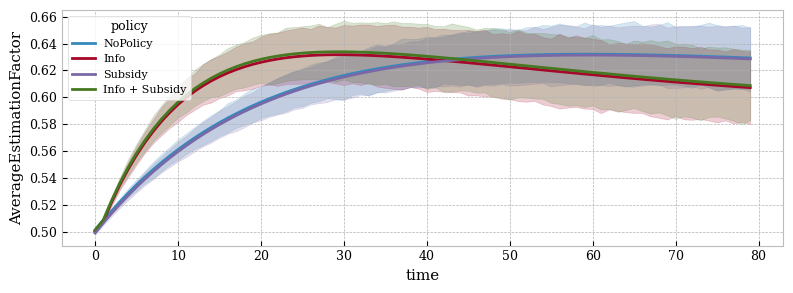

In [138]:
df_tmp = df_all_adapt

sns.lineplot(data=df_tmp, x="time", y="AverageEstimationFactor", hue="policy")
utils.savefig("lineplot-estimation-factore-policy.pdf", FIG_DIR)
plt.show()

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/lineplot-risk-aversion-policy.pdf


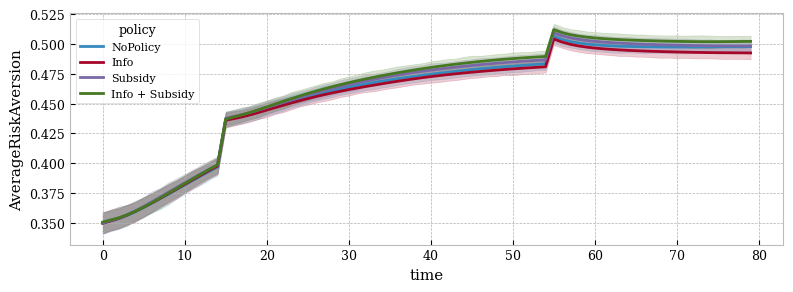

In [146]:
df_tmp = df_all_adapt

sns.lineplot(data=df_tmp, x="time", y="AverageRiskAversion", hue="policy")
utils.savefig("lineplot-risk-aversion-policy.pdf", FIG_DIR)
plt.show()

[LOG]: Saved figure to /home/simon/Documents/Study/Delft/AE-MSc1/ABM/project/abm-flood-adaptation/analysis/../output/figures/information-abundance.pdf


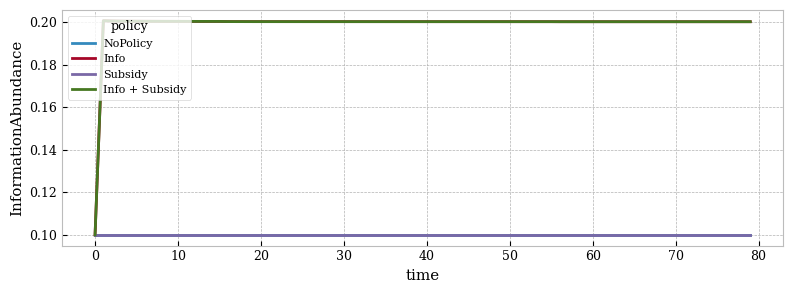

In [145]:
df_tmp = df_all_adapt

sns.lineplot(data=df_tmp, x="time", y="InformationAbundance", hue="policy")
utils.savefig("information-abundance.pdf", FIG_DIR)
plt.show()